In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix 
import math
import optuna
from optuna.trial import TrialState
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 

import optuna
from optuna.trial import TrialState

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data[0][0].shape

torch.Size([28, 28])

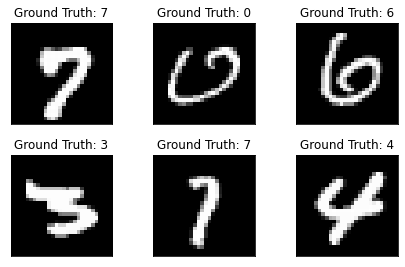

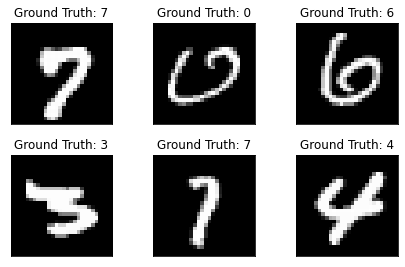

In [7]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
# layers = []
# in_features = 1
# layers.append(bnn.BayesConv2d(0, 0.1, 1, 10, kernel_size=5))
# layers.append(nn.ReLU())
# layers.append(nn.MaxPool2d(2, 2))
# layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=20))
# layers.append(nn.ReLU())
# layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=20))
# model = nn.Sequential(*layers)

In [10]:
model = Net()
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [11]:
# Convert Conv2d -> BayesConv2d
from torchhk import transform_model
transform_model(model, nn.Conv2d, bnn.BayesConv2d, 
                args={"prior_mu":0, "prior_sigma":0.01, "in_channels" : ".in_channels",
                      "out_channels" : ".out_channels", "kernel_size" : ".kernel_size",
                      "stride" : ".stride", "padding" : ".padding", "bias":".bias"
                     }, 
                attrs={"weight_mu" : ".weight"})
# Convert Linear -> BayesLinear
transform_model(model, nn.Linear, bnn.BayesLinear, 
            args={"prior_mu":0, "prior_sigma":0.01, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\torchhk\transform.py:34: Warning: 
 * Caution : The Input Model is CHANGED because inplace=True.
  warnings.warn("\n * Caution : The Input Model is CHANGED because inplace=True.", Warning)


Net(
  (conv1): BayesConv2d(0, 0.01, 1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): BayesConv2d(0, 0.01, 10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=320, out_features=50, bias=True)
  (fc2): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=50, out_features=10, bias=True)
)

In [12]:
model

Net(
  (conv1): BayesConv2d(0, 0.01, 1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): BayesConv2d(0, 0.01, 10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=320, out_features=50, bias=True)
  (fc2): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=50, out_features=10, bias=True)
)

In [13]:
ce_loss = nn.CrossEntropyLoss()
klloss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
klweight = 0.01

optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=momentum)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss_1 = F.nll_loss(output, target)
        kl = klloss(model)
        total_cost = loss_1 + klweight*kl
        
        total_cost.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), total_cost.item()))
            train_losses.append(total_cost.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#             print("loss_1", loss_1)
#             print("kl", kl)

In [16]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            kl = klloss(model)
            test_loss += (F.nll_loss(output, target, size_average=False).item() + klweight*kl)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
#     print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#     test_loss, correct, len(test_loader.dataset),
#     100 * correct / len(test_loader.dataset)))
    print("AVG loss", test_loss)
    print("Correct", correct)
    print("Accuracy", correct/len(test_loader.dataset))

In [17]:
n_epochs = 2
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


AVG loss tensor([2.3098])
Correct tensor(839)
Accuracy tensor(0.0839)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.357727
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.394563
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.366388
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.348394
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.355020
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.336083
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.325854
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.294675
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.273309
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.264975
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.231636
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.213125
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.140196
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.078470
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.014605
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.951825
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.732737
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.754550
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.632727
Train Epo

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.373705
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.604780
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.464864
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.579491
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.381033
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.416925
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.540056
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.456861
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.325146
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.452458
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.330463
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.454256
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.300210
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.538685
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.476724
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.883667
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.600733
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.492348
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.293090
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.397540


In [18]:
test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


AVG loss tensor([0.1316])
Correct tensor(9614)
Accuracy tensor(0.9614)


In [19]:
test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


AVG loss tensor([0.1339])
Correct tensor(9583)
Accuracy tensor(0.9583)


In [20]:
from alibi.explainers import CEM

In [25]:
cnn = Net()

In [36]:
example_data[15][0].shape

torch.Size([28, 28])

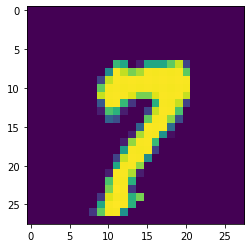

In [30]:
idx = 15
X = example_data[15][0]
plt.imshow(X.reshape(28, 28));

In [38]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + example_data[15][0].shape  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (0,9)  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [56]:
a = list(shape)

In [59]:
shape = torch.IntTensor(a)
shape

tensor([ 1, 28, 28], dtype=torch.int32)

In [46]:
type(example_data[15][0])

torch.Tensor

In [60]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

TypeError: Tensor is not a sequence

In [303]:
def class_prob(img, iterations):
    pre_list = []
    prob_list = []
    for i in range(iterations):
        output = model(img)
        prob_list.append(F.softmax(output[0], dim=0).tolist())
        pred = output.data.max(1, keepdim=True)[1][0][0].item()
        pre_list.append(pred)
    return set(pre_list), pd.DataFrame.from_records(prob_list).transpose()

In [304]:
def mean_std(dataframe_prob):
    dataframe_prob['mean'] = dataframe_prob.iloc[:, 0:].mean(axis=1)
    dataframe_prob['std'] = dataframe_prob.iloc[:, 0:-1].std(axis=1)
    return dataframe_prob, dataframe_prob['mean'], dataframe_prob['std']

In [559]:
predictions, prob_df = class_prob(example_data[4].unsqueeze(0), 1000)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [562]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,2.600917e-07,3.236939e-07,1.992599e-07,8.919110e-08,3.371642e-07,2.445356e-07,3.566287e-07,1.084213e-07,2.681313e-07,1.976827e-07,...,7.019357e-07,3.359553e-07,2.206946e-07,1.044806e-07,4.791241e-07,5.422776e-07,1.238460e-07,2.008527e-07,1.578255e-07,2.647721e-07
1,3.664018e-03,7.551812e-03,7.147421e-04,6.930384e-04,1.291406e-03,1.311220e-03,2.342260e-03,1.174251e-03,2.160916e-03,2.933203e-03,...,2.220036e-03,8.375304e-04,2.634748e-03,1.718577e-03,3.490141e-03,1.572105e-03,7.189909e-04,4.126312e-03,4.607544e-03,1.073124e-03
2,4.644213e-03,5.661688e-03,2.178398e-03,2.955002e-03,3.738270e-03,1.836082e-03,2.875187e-03,3.192559e-03,3.949783e-03,2.805997e-03,...,6.833476e-03,1.918774e-03,3.908761e-03,3.577210e-03,5.490650e-03,3.504116e-03,2.717461e-03,4.283141e-03,2.595053e-03,2.591962e-03
3,1.870158e-03,4.595970e-03,1.996624e-03,1.039894e-03,1.628533e-03,1.232529e-03,1.645098e-03,1.699867e-03,2.283464e-03,1.611625e-03,...,3.331261e-03,2.131254e-03,2.314883e-03,1.819873e-03,3.068503e-03,1.433077e-03,1.263334e-03,1.619244e-03,2.121783e-03,2.870187e-03
4,7.819582e-07,8.562041e-07,4.782677e-07,2.580727e-07,1.214949e-06,5.377934e-07,3.561845e-07,5.294428e-07,1.016414e-06,1.562729e-06,...,1.254118e-06,9.448536e-07,6.834503e-07,4.486496e-07,2.121862e-06,1.011281e-06,4.342807e-07,5.527147e-07,9.610944e-07,7.951943e-07
5,6.025728e-06,1.271987e-05,5.660695e-06,1.973865e-06,4.028335e-06,6.996721e-06,5.783516e-06,4.934543e-06,1.172177e-05,5.736804e-06,...,1.409538e-05,1.739144e-05,6.216797e-06,3.874079e-06,1.448910e-05,8.657672e-06,5.135921e-06,6.076213e-06,1.129307e-05,9.754513e-06
6,2.397391e-09,7.069840e-09,1.903318e-09,6.408156e-10,2.058403e-09,2.125099e-09,2.295950e-09,1.810219e-09,3.511499e-09,4.040973e-09,...,5.988568e-09,2.068069e-09,1.569895e-09,1.230255e-09,5.468701e-09,5.190290e-09,1.149535e-09,3.049541e-09,3.735881e-09,4.970194e-09
7,9.879348e-01,9.799715e-01,9.933794e-01,9.946076e-01,9.916313e-01,9.939080e-01,9.920074e-01,9.929810e-01,9.902604e-01,9.912286e-01,...,9.849312e-01,9.932048e-01,9.876202e-01,9.910830e-01,9.835791e-01,9.898142e-01,9.941174e-01,9.876218e-01,9.886466e-01,9.918653e-01
8,5.790740e-04,5.794166e-04,2.737357e-04,1.485267e-04,2.213843e-04,2.278241e-04,2.752235e-04,1.445486e-04,3.594116e-04,1.367766e-04,...,4.281562e-04,4.119079e-04,5.846943e-04,2.040587e-04,4.795964e-04,2.582748e-04,8.719928e-05,3.973015e-04,2.301708e-04,3.388884e-04
9,1.300594e-03,1.625667e-03,1.450768e-03,5.536025e-04,1.483542e-03,1.476437e-03,8.483717e-04,8.021677e-04,9.729335e-04,1.276320e-03,...,2.239763e-03,1.477060e-03,2.929619e-03,1.592833e-03,3.874911e-03,3.407962e-03,1.089938e-03,1.945368e-03,1.786491e-03,1.249652e-03


In [563]:
df, df_mean, df_std = mean_std(prob_df)

In [564]:
 df_mean, df_std

(0    2.241584e-07
 1    2.264740e-03
 2    3.552826e-03
 3    1.927028e-03
 4    7.223874e-07
 5    6.394621e-06
 6    2.456824e-09
 7    9.904684e-01
 8    2.922731e-04
 9    1.487356e-03
 Name: mean, dtype: float64,
 0    1.471038e-07
 1    1.368240e-03
 2    1.687277e-03
 3    8.555094e-04
 4    4.285532e-07
 5    3.332240e-06
 6    1.781208e-09
 7    3.458796e-03
 8    1.511615e-04
 9    6.510309e-04
 Name: std, dtype: float64)

In [565]:

pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]
for i in range(200):
    
    predictions, prob_df = class_prob(example_data[i].unsqueeze(0), 100)
    predictions_list = list(predictions)
    
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)


<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


multiple solutions in 11
multiple solutions in 22
multiple solutions in 23
multiple solutions in 31
multiple solutions in 53
multiple solutions in 69
multiple solutions in 73
multiple solutions in 148
multiple solutions in 150
multiple solutions in 185


In [566]:
print(list_multiple_sol)

[11, 22, 23, 31, 53, 69, 73, 148, 150, 185]


In [567]:
def plot_figures(images_index_list, all_predictions = [], all_mean_sol =[], all_std_sol=[]):
    fig = plt.figure()
    counter = 0
    for i in images_index_list:
        plt.subplot(math.ceil(len(images_index_list)/3),3, 1 + counter)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
        counter += 1
    fig
    
    if all_predictions != []:
        counter = 1
        for i in images_index_list:
            print("~~~~~~~~~~~~~~~~~ Image " +str(counter)+ " ~~~~~~~~~~~~~~~~~")
            print("predictions", all_predictions[i], " ground truth", example_targets[i].item())
            print("mean:", all_mean_sol[i])
            print("std:", all_std_sol[i])
            counter+=1
            std_mean_saver = []
            if len(all_predictions[i])> 1:
                for n in range(len(all_predictions[i])):
                    std_mean = all_std_sol[i][n]/all_mean_sol[i][n]
                    std_mean_saver.append(std_mean)
                    
                print("std/mean:", std_mean_saver)
                
            else:
                print("std/mean:", all_std_sol[i]/all_mean_sol[i])


        

In [581]:
print(len(list_multiple_sol))

10


~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [8, 4]  ground truth 8
mean: [0.6112609332799912, 0.342826183811834]
std: [0.11654027306465502, 0.11329207346639691]
std/mean: [0.19065552323016388, 0.33046505435121376]
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [0, 6]  ground truth 6
mean: [0.4585582022368908, 0.461947784088244]
std: [0.10519410225948776, 0.10756600640085207]
std/mean: [0.22940185508914868, 0.2328531710854666]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [2, 7]  ground truth 7
mean: [0.19487077422440052, 0.7665932040771132]
std: [0.07934738420550969, 0.08333243537430038]
std/mean: [0.40717949893368, 0.10870489710983376]
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [9, 4]  ground truth 9
mean: [0.7457921785116196, 0.2187644133205653]
std: [0.08162482902163097, 0.07930075807447572]
std/mean: [0.10944715079277174, 0.3624938666705026]
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [9, 4]  ground truth 4
mean: [0.3132341617

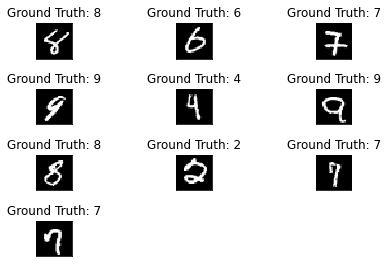

In [568]:
plot_figures(list_multiple_sol, all_pre, all_mean, all_var)

In [570]:
# Finding low probability and hight probability lists, top 9
std_sol_sorted = sorted(std_sol, reverse=True)
mean_sol_sorted = sorted(mean_sol, reverse=False)
mean_sol_sorted_index = []
std_sol_sorted_index = []
for i in range(9):
    mean_sol_sorted_index.append(mean_sol.index(mean_sol_sorted[i]))
    std_sol_sorted_index.append(std_sol.index(std_sol_sorted[i]))

In [574]:
# Only single predictions
sorted(mean_sol_sorted_index), sorted(std_sol_sorted_index)

([3, 45, 61, 65, 126, 132, 147, 165, 197],
 [3, 26, 45, 61, 65, 90, 147, 163, 165])

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [3]  ground truth 5
mean: 0.5075238376855851
std: 0.06498510034160516
std/mean: 0.12804344449701283
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 8
mean: 0.5401610028743744
std: 0.05698977803920184
std/mean: 0.10550516926609008
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 9
mean: 0.6372412741184235
std: 0.050783559885549875
std/mean: 0.07969282899291984
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 8
mean: 0.6381052148342132
std: 0.09906681138589624
std/mean: 0.15525153075521392
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [3]  ground truth 3
mean: 0.6412860026955605
std: 0.06995926256602543
std/mean: 0.10909214028056276
~~~~~~~~~~~~~~~~~ Image 6 ~~~~~~~~~~~~~~~~~
predictions [4]  ground truth 4
mean: 0.6979564142227173
std: 0.06236542828699607
std/mean: 0.08935433075208522
~~~~~~~~~~~~~~~~~ Image 7 ~~~~~~~~~~~~~~~~~
predictions [9]  gr

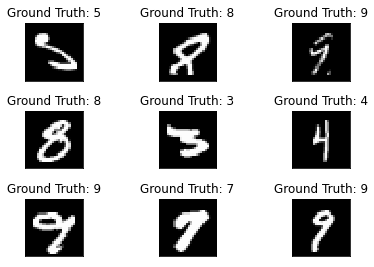

In [575]:
# Lowest mean to highest
plot_figures(mean_sol_sorted_index, all_pre, all_mean, all_var)

In [42]:
list_multiple_sol, std_sol_sorted_index

([11, 22, 26, 53, 69, 73, 126, 148, 150, 165, 185],
 [23, 31, 61, 147, 3, 45, 163, 65, 132])

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 8
mean: 0.6381052148342132
std: 0.09906681138589624
std/mean: 0.15525153075521392
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 9
mean: 0.6988408035039901
std: 0.09142646525758882
std/mean: 0.1308258830897913
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [5]  ground truth 5
mean: 0.7938799279928207
std: 0.07794456688354448
std/mean: 0.09818180827497802
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [0]  ground truth 0
mean: 0.7285614031553268
std: 0.07500585327148378
std/mean: 0.10295062701186325
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [3]  ground truth 3
mean: 0.6412860026955605
std: 0.06995926256602543
std/mean: 0.10909214028056276
~~~~~~~~~~~~~~~~~ Image 6 ~~~~~~~~~~~~~~~~~
predictions [3]  ground truth 5
mean: 0.5075238376855851
std: 0.06498510034160516
std/mean: 0.12804344449701283
~~~~~~~~~~~~~~~~~ Image 7 ~~~~~~~~~~~~~~~~~
predictions [9]  grou

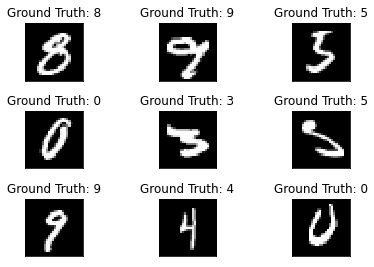

In [576]:
# Highest std to lowest
plot_figures(std_sol_sorted_index, all_pre, all_mean, all_var)
# Note that they have lower std than the multiple predictions list.

In [577]:
# Error

error_list = []
# prob_list2 = []
for i in range(200):
    output = model(example_data[i].unsqueeze(0))
    
    pred = output.data.max(1, keepdim=True)[1]
    if example_targets[i].unsqueeze(0).item() != pred.item():
        error_list.append(i)
#         prob_list2.append(F.softmax(output[0], dim=0).max(0)[0].item())
        
        
print(error_list)


<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[65, 68, 69, 126, 132, 141, 148, 150, 193]


In [578]:
sorted(list_multiple_sol), sorted(error_list)

([11, 22, 23, 31, 53, 69, 73, 148, 150, 185],
 [65, 68, 69, 126, 132, 141, 148, 150, 193])

In [579]:
num_mult_error = sum(el in list_multiple_sol for el in error_list)
print(num_mult_error, "of the", len(error_list), "errors are in list_multiple_sol")
print("which is:", num_mult_error/len(error_list))
print("The length of list_multiple_sol is:", len(list_multiple_sol), "which implies that", num_mult_error/len(list_multiple_sol))

3 of the 9 errors are in list_multiple_sol
which is: 0.3333333333333333
The length of list_multiple_sol is: 10 which implies that 0.3


In [582]:
for i in error_list:
    if len(all_pre[i]) == 1:
        print("Image:", i, "mean:", all_mean[i], "std:", all_var[i])
        print("std/mean", all_var[i]/all_mean[i], "\n")

Image: 65 mean: 0.5075238376855851 std: 0.06498510034160516
std/mean 0.12804344449701283 

Image: 68 mean: 0.9305937087535858 std: 0.02175919224000287
std/mean 0.023382053881652168 

Image: 126 mean: 0.5401610028743744 std: 0.05698977803920184
std/mean 0.10550516926609008 

Image: 132 mean: 0.7079236453771591 std: 0.05360426196433399
std/mean 0.07572040051830074 

Image: 141 mean: 0.9482946193218231 std: 0.02266936220144378
std/mean 0.023905400009182662 

Image: 193 mean: 0.9240491437911987 std: 0.02212110396973304
std/mean 0.02393931547728548 



~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [3]  ground truth 5
mean: 0.5075238376855851
std: 0.06498510034160516
std/mean: 0.12804344449701283
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8]  ground truth 3
mean: 0.9305937087535858
std: 0.02175919224000287
std/mean: 0.023382053881652168
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [9, 7]  ground truth 9
mean: [0.41316501319408416, 0.4898797154721088]
std: [0.060575717608437794, 0.0604621066842372]
std/mean: [0.1466138605012578, 0.12342235200730535]
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 8
mean: 0.5401610028743744
std: 0.05698977803920184
std/mean: 0.10550516926609008
~~~~~~~~~~~~~~~~~ Image 5 ~~~~~~~~~~~~~~~~~
predictions [9]  ground truth 7
mean: 0.7079236453771591
std: 0.05360426196433399
std/mean: 0.07572040051830074
~~~~~~~~~~~~~~~~~ Image 6 ~~~~~~~~~~~~~~~~~
predictions [4]  ground truth 9
mean: 0.9482946193218231
std: 0.02266936220144378
std/mean: 0.0239054000

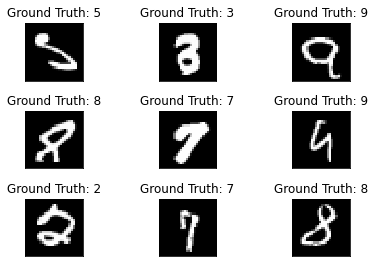

In [583]:
plot_figures(error_list, all_pre, all_mean, all_var)

In [584]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if all_var[i] <= 0.05:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])

        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 68 all_mean[i] 0.9305937087535858 all_var[i] 0.02175919224000287 std/mean 0.023382053881652168
i 141 all_mean[i] 0.9482946193218231 all_var[i] 0.02266936220144378 std/mean 0.023905400009182662
i 193 all_mean[i] 0.9240491437911987 all_var[i] 0.02212110396973304 std/mean 0.02393931547728548

num_prediction_counter 175
correct_counter 172
precentage 0.9828571428571429


In [585]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if all_mean[i] >= 0.85:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])

        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 68 all_mean[i] 0.9305937087535858 all_var[i] 0.02175919224000287 std/mean 0.023382053881652168
i 141 all_mean[i] 0.9482946193218231 all_var[i] 0.02266936220144378 std/mean 0.023905400009182662
i 193 all_mean[i] 0.9240491437911987 all_var[i] 0.02212110396973304 std/mean 0.02393931547728548

num_prediction_counter 175
correct_counter 172
precentage 0.9828571428571429


In [586]:
num_prediction_counter = 0
correct_counter = 0
for i in range(len(all_pre)):
    if len(all_pre[i]) == 1:
        if (all_var[i]/all_mean[i]) <= 0.068:
            num_prediction_counter += 1
            if all_pre[i][0] == example_targets[i].item():
                correct_counter+=1
            else:
                print("i", i, "all_mean[i]", all_mean[i], "all_var[i]", all_var[i], "std/mean", all_var[i]/all_mean[i])
        
print("\nnum_prediction_counter", num_prediction_counter)
print("correct_counter", correct_counter)
print("precentage", correct_counter/num_prediction_counter)

i 68 all_mean[i] 0.9305937087535858 all_var[i] 0.02175919224000287 std/mean 0.023382053881652168
i 141 all_mean[i] 0.9482946193218231 all_var[i] 0.02266936220144378 std/mean 0.023905400009182662
i 193 all_mean[i] 0.9240491437911987 all_var[i] 0.02212110396973304 std/mean 0.02393931547728548

num_prediction_counter 177
correct_counter 174
precentage 0.9830508474576272


In [587]:
predictions, prob_df = class_prob(example_data[0].unsqueeze(0), 1000)
df_mean_std, df_mean, df_std = mean_std(prob_df)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [588]:
def select_given_prob(df_prob, mean_var = False):
    df_copy = df_prob.copy()
    extra_columns = 0
    if mean_var:
        extra_columns = 2
        
    df_copy['count']= 0
    for i in range(len(df_copy.columns)-1-extra_columns):
        number_pre_data = df_copy.iloc[:, i].sample(weights=df_mean, n=1, replace=True)
        number_pre = number_pre_data.axes[0][0]
        df_copy['count'].iloc[number_pre] += 1
    
    num_pre = df_copy['count'].sum() 
    df_copy['ratio']= 0
    for i in range(10):
        df_copy['ratio'].iloc[i] = df_copy['count'].iloc[i]/num_pre

    return df_copy, df_copy['count'], df_copy['ratio']
    
    

In [589]:
df_copy, df_copy_count, df_copy_ratio = select_given_prob(prob_df, True)
df_copy

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,mean,std,count,ratio
0,1.641254e-05,3.444722e-06,1.220832e-05,6.011246e-06,7.367011e-06,8.551320e-06,2.451213e-06,1.182836e-05,7.251062e-06,6.876360e-06,...,2.059473e-06,8.438346e-06,1.857212e-05,4.329042e-06,2.988744e-06,6.235428e-06,9.053202e-06,5.187138e-06,0,0.000
1,3.587446e-07,2.607970e-07,2.994717e-07,1.141725e-07,1.707599e-07,1.965522e-07,5.610839e-08,2.493295e-07,1.406697e-07,1.925961e-07,...,7.587892e-08,1.477611e-07,2.554727e-07,1.164151e-07,1.212730e-07,9.153414e-08,2.019728e-07,1.424285e-07,0,0.000
2,1.915689e-05,2.077720e-05,2.572294e-05,5.763337e-06,1.345369e-05,3.248268e-05,7.864689e-06,1.335291e-05,8.691007e-06,1.226777e-05,...,6.116250e-06,5.225905e-06,3.229323e-05,8.102161e-06,9.281873e-06,1.986304e-05,1.430237e-05,8.008635e-06,0,0.000
3,2.674218e-04,2.287035e-04,1.387007e-04,9.630989e-05,1.635465e-04,1.611570e-04,9.342146e-05,1.110864e-04,7.419282e-05,1.139293e-04,...,4.395765e-05,6.900172e-05,1.235630e-04,7.454226e-05,1.099772e-04,1.069498e-04,1.434033e-04,6.916617e-05,0,0.000
4,2.383860e-06,6.299651e-06,3.995326e-06,6.686044e-07,3.014174e-06,1.757641e-06,6.893658e-07,9.824141e-07,9.541913e-07,1.717448e-06,...,7.538582e-07,1.799577e-06,5.218657e-06,4.126262e-06,8.876015e-07,1.611437e-06,3.033778e-06,2.067062e-06,0,0.000
5,1.656149e-04,4.134831e-05,5.982553e-05,5.089376e-05,3.401654e-05,5.589946e-05,4.328327e-05,9.242298e-05,3.923837e-05,4.234369e-05,...,2.146779e-05,3.655090e-05,8.023904e-05,5.380729e-05,3.335774e-05,3.675300e-05,7.208377e-05,3.868213e-05,0,0.000
6,2.865728e-09,1.288351e-09,9.835462e-10,4.115345e-10,1.056008e-09,8.076053e-10,2.861637e-10,5.562894e-10,8.586746e-10,1.996397e-09,...,2.481563e-10,6.998984e-10,4.137009e-09,1.199131e-09,4.389759e-10,8.351073e-10,1.210465e-09,9.735925e-10,0,0.000
7,9.638144e-01,9.666368e-01,9.632401e-01,9.874693e-01,9.625368e-01,9.638107e-01,9.805643e-01,9.816127e-01,9.819332e-01,9.742129e-01,...,9.790622e-01,9.727259e-01,9.447629e-01,9.661189e-01,9.786580e-01,9.785531e-01,9.683796e-01,1.217707e-02,975,0.975
8,8.197091e-05,1.291447e-04,1.811246e-04,2.413824e-05,9.636499e-05,1.606258e-04,2.784071e-05,6.197728e-05,4.163734e-05,4.491983e-05,...,2.727819e-05,4.982645e-05,1.751586e-04,5.460727e-05,5.438870e-05,8.232646e-05,8.602056e-05,4.666821e-05,0,0.000
9,3.563229e-02,3.293320e-02,3.633804e-02,1.234683e-02,3.714532e-02,3.576865e-02,1.926005e-02,1.809541e-02,1.789469e-02,2.556487e-02,...,2.083606e-02,2.710314e-02,5.480180e-02,3.368150e-02,2.113107e-02,2.119308e-02,3.129227e-02,1.210019e-02,25,0.025


In [594]:
current_path = r'C:\Users\richa\Pictures\Saved Pictures\research'

In [595]:
from os import listdir
from os.path import isfile, join
image_names = [f for f in listdir(current_path) if isfile(join(current_path, f))]

In [596]:
image_names

['Cat.jpg', 'Cosmos.jpg', 'flower.jpg', 'fur_1.jpg', 'fur_2.jpg', 'Turtle.jpg']

In [597]:
current_path

'C:\\Users\\richa\\Pictures\\Saved Pictures\\research'

In [598]:
from  PIL import Image
import cv2
num_img = []
images = []
num_img.append(len(os.listdir(current_path)))
for filename in os.listdir(current_path):
    img = Image.open(os.path.join(current_path, filename))
    img = img.convert('1') 
#     img.save('greyscale.png')
#     img = cv2.imwrite('myImage.png',img)
    if img is not None:
    
        images.append(img)

In [599]:
images, num_img

([<PIL.Image.Image image mode=1 size=5026x3458 at 0x20A67E12FD0>,
  <PIL.Image.Image image mode=1 size=1920x1080 at 0x20A02FD6730>,
  <PIL.Image.Image image mode=1 size=3120x4160 at 0x20A012C93A0>,
  <PIL.Image.Image image mode=1 size=6144x8192 at 0x20A1F0A0910>,
  <PIL.Image.Image image mode=1 size=5695x3797 at 0x20A1F0A0FA0>,
  <PIL.Image.Image image mode=1 size=1920x1200 at 0x20A1F0A08E0>],
 [6])

In [600]:
# ? 
from torchvision import transforms
transform=torchvision.transforms.Compose([
                                transforms.Resize(28),
                                transforms.CenterCrop(28),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [601]:
from sklearn import preprocessing
list_input_tensor = []
list_input_batch = []
for item in range(num_img[0]):
    input_tensor = transform(images[item])
    input_batch = input_tensor.unsqueeze(0)
    list_input_tensor.append(input_tensor)
    list_input_batch.append(input_batch)

In [602]:
len(list_input_batch)

6

In [603]:
list_input_batch[1][0].shape

torch.Size([1, 28, 28])

In [604]:
example_data[0].shape

torch.Size([1, 28, 28])

In [605]:
def plot_figures_non_numeric(images_list, names_list, eva_list = [] ,all_predictions = [], all_mean_sol =[], all_std_sol=[]):
    fig = plt.figure()
    counter = 0
    for i in range(len(eva_list)):
        plt.subplot(math.ceil(len(eva_list)/3),3, 1 + counter)
        plt.tight_layout()
        plt.imshow(images_list[i][0][0], cmap='gray', interpolation='none')
        plt.title("Image Name: {}".format(names_list[i]))
        plt.xticks([])
        plt.yticks([])
        counter += 1
    fig
    
    if all_predictions != []:
        counter = 1
        for i in eva_list:
            print("~~~~~~~~~~~~~~~~~ Image " +str(counter)+ " ~~~~~~~~~~~~~~~~~")
            print("predictions", all_predictions[i], " Image Name", names_list[i])
            print("mean:", all_mean_sol[i])
            print("std:", all_std_sol[i])
            counter+=1
            std_mean_saver = []
            if len(all_predictions[i])> 1:
                for n in range(len(all_predictions[i])):
                    std_mean = all_std_sol[i][n]/all_mean_sol[i][n]
                    std_mean_saver.append(std_mean)
                    
                print("std/mean:", std_mean_saver)
                
            else:
                print("std/mean:", all_std_sol[i][0]/all_mean_sol[i][0])

In [606]:
all_images = [x for x in range(len(list_input_batch))]
all_images

[0, 1, 2, 3, 4, 5]

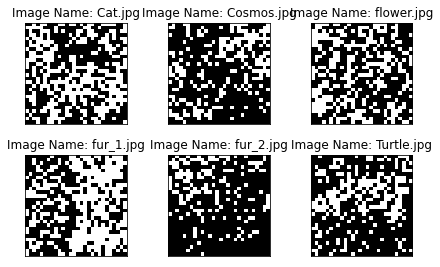

In [607]:
plot_figures_non_numeric(list_input_batch, image_names, all_images)

In [169]:
list_input_batch[0][0].shape

torch.Size([1, 28, 28])

In [608]:
pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]
for i in range(len(list_input_batch)):

    predictions, prob_df = class_prob(list_input_batch[i][0].unsqueeze(0), 1000)
    predictions_list = list(predictions)
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append([df_std[predictions_list[0]]])
        mean_sol.append([df_mean[predictions_list[0]]])
        pre.append(predictions_list[0])
        
        all_var.append([df_std[predictions_list[0]]])
        all_mean.append([df_mean[predictions_list[0]]])
        all_pre.append([predictions_list])
    

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


multiple solutions in 1
multiple solutions in 2
multiple solutions in 3
multiple solutions in 4
multiple solutions in 5


[6]

In [609]:
list_multiple_sol

[1, 2, 3, 4, 5]

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [6]  Image Name Cat.jpg
mean: [0.7069513559937477]
std: [0.04542963059404371]
std/mean: 0.06426132464260453
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [0, 2, 3, 7]  Image Name Cosmos.jpg
mean: [0.2318331192433834, 0.13676782598325946, 0.11365954380169453, 0.15829360366538733]
std: [0.034084339613946815, 0.020517610463512873, 0.014689125770641284, 0.022693989590072478]
std/mean: [0.14702101117038563, 0.1500178153451401, 0.12923794412081993, 0.14336643467947513]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [8, 2, 3]  Image Name flower.jpg
mean: [0.20833966514468194, 0.20856782912287825, 0.18227986966761378]
std: [0.01885589411846712, 0.024768000287977016, 0.01845505634201033]
std/mean: [0.09050554106138456, 0.11875273570299708, 0.10124571833227121]
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [9, 3, 5, 7]  Image Name fur_1.jpg
mean: [0.12877456165850162, 0.19546694942884357, 0.13696034577121155, 0.

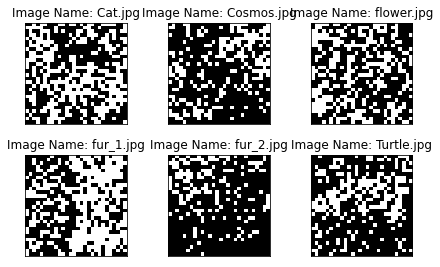

In [266]:
plot_figures_non_numeric(list_input_batch, image_names, all_images , all_pre, all_mean, all_var)

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [0, 2, 3, 7]  Image Name Cosmos.jpg
mean: [0.2318331192433834, 0.13676782598325946, 0.11365954380169453, 0.15829360366538733]
std: [0.034084339613946815, 0.020517610463512873, 0.014689125770641284, 0.022693989590072478]
std/mean: [0.14702101117038563, 0.1500178153451401, 0.12923794412081993, 0.14336643467947513]
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [8, 2, 3]  Image Name flower.jpg
mean: [0.20833966514468194, 0.20856782912287825, 0.18227986966761378]
std: [0.01885589411846712, 0.024768000287977016, 0.01845505634201033]
std/mean: [0.09050554106138456, 0.11875273570299708, 0.10124571833227121]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [9, 3, 5, 7]  Image Name fur_1.jpg
mean: [0.12877456165850162, 0.19546694942884357, 0.13696034577121155, 0.15955896626578664]
std: [0.015500313906152516, 0.022496264488907167, 0.02057585857973478, 0.025431417950541012]
std/mean: [0.12036782503098657, 0.1150898632973067, 

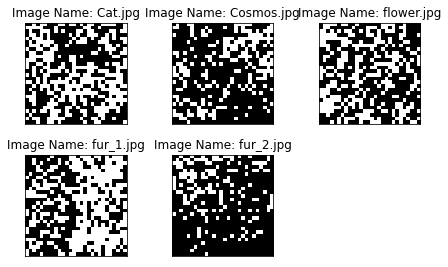

In [262]:
plot_figures_non_numeric(list_input_batch, image_names, list_multiple_sol , all_pre, all_mean, all_var)

In [187]:
def select_given_prob(df_prob, mean_var = False):
    df_copy = df_prob.copy()
    extra_columns = 0
    if mean_var:
        extra_columns = 2
        
    df_copy['count']= 0
    for i in range(len(df_copy.columns)-1-extra_columns):
        number_pre_data = df_copy.iloc[:, i].sample(weights=df_mean, n=1, replace=True)
        number_pre = number_pre_data.axes[0][0]
        df_copy['count'].iloc[number_pre] += 1
    
    num_pre = df_copy['count'].sum() 
    df_copy['ratio']= 0
    for i in range(10):
        df_copy['ratio'].iloc[i] = df_copy['count'].iloc[i]/num_pre

    return df_copy, df_copy['count'], df_copy['ratio']
    
    

In [190]:
pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]

count_pre_all_list = []
ratio_pre_all_list = []
for i in range(len(list_input_batch)):

    predictions, prob_df = class_prob(list_input_batch[i][0].unsqueeze(0), 1000)
    predictions_list = list(predictions)
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)
    
    df_copy, df_copy_count, df_copy_ratio = select_given_prob(prob_df, True)
    count_pre_all_list.append(list(df_copy_count))
    ratio_pre_all_list.append(list(df_copy_ratio))

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

multiple solutions in 1


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

multiple solutions in 2


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

multiple solutions in 3


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

multiple solutions in 4


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


multiple solutions in 5


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [191]:
count_pre_all_list

[[15, 21, 30, 4, 120, 89, 682, 5, 22, 12],
 [226, 40, 140, 109, 24, 91, 48, 148, 72, 102],
 [62, 56, 216, 174, 40, 47, 24, 89, 218, 74],
 [39, 81, 61, 208, 55, 141, 22, 164, 97, 132],
 [41, 162, 91, 130, 72, 103, 50, 133, 99, 119],
 [6, 3, 12, 62, 35, 58, 0, 347, 76, 401]]

In [192]:
ratio_pre_all_list

[[0.015, 0.021, 0.03, 0.004, 0.12, 0.089, 0.682, 0.005, 0.022, 0.012],
 [0.226, 0.04, 0.14, 0.109, 0.024, 0.091, 0.048, 0.148, 0.072, 0.102],
 [0.062, 0.056, 0.216, 0.174, 0.04, 0.047, 0.024, 0.089, 0.218, 0.074],
 [0.039, 0.081, 0.061, 0.208, 0.055, 0.141, 0.022, 0.164, 0.097, 0.132],
 [0.041, 0.162, 0.091, 0.13, 0.072, 0.103, 0.05, 0.133, 0.099, 0.119],
 [0.006, 0.003, 0.012, 0.062, 0.035, 0.058, 0.0, 0.347, 0.076, 0.401]]

In [268]:
all_mean

[[0.7069513559937477],
 [0.2318331192433834,
  0.13676782598325946,
  0.11365954380169453,
  0.15829360366538733],
 [0.20833966514468194, 0.20856782912287825, 0.18227986966761378],
 [0.12877456165850162,
  0.19546694942884357,
  0.13696034577121155,
  0.15955896626578664],
 [0.161879021756351,
  0.13082254772009755,
  0.1052441785897011,
  0.12306860200859404,
  0.11167187865724638],
 [0.3872883517742157, 0.3271652323164989]]

~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [6]  Image Name Cat.jpg
mean: [0.7069513559937477]
std: [0.04542963059404371]
std/mean: 0.06426132464260453
~~~~~~~~~~~~~~~~~ Image 2 ~~~~~~~~~~~~~~~~~
predictions [0, 2, 3, 7]  Image Name Cosmos.jpg
mean: [0.2318331192433834, 0.13676782598325946, 0.11365954380169453, 0.15829360366538733]
std: [0.034084339613946815, 0.020517610463512873, 0.014689125770641284, 0.022693989590072478]
std/mean: [0.14702101117038563, 0.1500178153451401, 0.12923794412081993, 0.14336643467947513]
~~~~~~~~~~~~~~~~~ Image 3 ~~~~~~~~~~~~~~~~~
predictions [8, 2, 3]  Image Name flower.jpg
mean: [0.20833966514468194, 0.20856782912287825, 0.18227986966761378]
std: [0.01885589411846712, 0.024768000287977016, 0.01845505634201033]
std/mean: [0.09050554106138456, 0.11875273570299708, 0.10124571833227121]
~~~~~~~~~~~~~~~~~ Image 4 ~~~~~~~~~~~~~~~~~
predictions [9, 3, 5, 7]  Image Name fur_1.jpg
mean: [0.12877456165850162, 0.19546694942884357, 0.13696034577121155, 0.

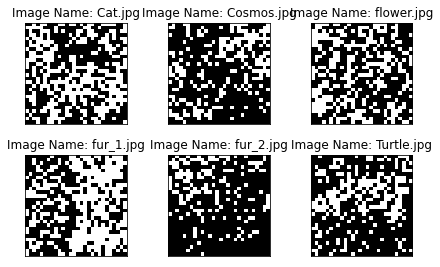

In [267]:
plot_figures_non_numeric(list_input_batch, image_names, all_images , all_pre, all_mean, all_var)

In [276]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [283]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784')
# # make each image color so lime_image works correctly
# X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0).astype(np.uint8)
# y_vec = mnist.target.astype(np.uint8)

In [610]:
example_data[0][0].shape

torch.Size([28, 28])

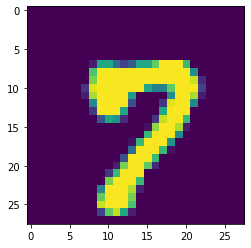

In [611]:
plt.imshow(example_data[0][0])

In [313]:
predictions, prob_df = class_prob(example_data[0].unsqueeze(0), 100)
predictions_list = list(predictions)

std_multiple_sol = []
mean_multiple_sol = []

std_saver = []
mean_saver = []
for m in predictions_list:
    df_mean_std, df_mean, df_std = mean_std(prob_df)
    std_saver.append(df_std[m])
    mean_saver.append(df_mean[m])
std_multiple_sol.append(std_saver)
mean_multiple_sol.append(mean_saver)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


~~~~~~~~~~~~~~~~~ Image 1 ~~~~~~~~~~~~~~~~~
predictions [7]  ground truth 7
mean: 0.9698585599660874
std: 0.010551658689591346
std/mean: 0.010879585049968834


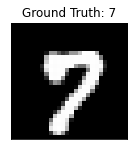

In [312]:
plot_figures([0], all_pre, all_mean, all_var)

In [612]:
predictions, prob_df = class_prob(example_data[0].unsqueeze(0), 100)
predictions_list = list(predictions)

std_multiple_sol = []
mean_multiple_sol = []

std_saver = []
mean_saver = []
for m in predictions_list:
    df_mean_std, df_mean, df_std = mean_std(prob_df)
    std_saver.append(df_std[m])
    mean_saver.append(df_mean[m])
std_multiple_sol.append(std_saver)
mean_multiple_sol.append(mean_saver)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [613]:
predictions_list, mean_saver, std_saver

([7], [0.9671562784910201], [0.013230732565157525])

In [327]:
mean_predicton_list = list(df_mean)
std_prediction_list = list(df_std)
print(mean_predicton_list)
print(std_prediction_list)

[9.865013315675243e-06, 2.0495647426344021e-07, 1.5586819681630005e-05, 0.00014853386190225138, 3.0200128310298168e-06, 7.553479437774513e-05, 1.3410633400989801e-09, 0.9677045750617981, 8.577989186960622e-05, 0.03195689941756427]
[6.614932517839598e-06, 1.4002913726041857e-07, 9.807575830493688e-06, 6.441811839059834e-05, 1.9850524131442615e-06, 4.376103232670685e-05, 1.3144085960613892e-09, 0.011402049244039522, 4.0376020083620064e-05, 0.011337443261177964]


In [ ]:
for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [331]:
for i in mean_predicton_list:
    print(mean_predicton_list.index(i))

0
1
2
3
4
5
6
7
8
9


In [332]:
tuple((p, mean_predicton_list.index(p), "class :" + str(mean_predicton_list.index(p))) for p in (mean_predicton_list))

((9.865013315675243e-06, 0, 'class :0'),
 (2.0495647426344021e-07, 1, 'class :1'),
 (1.5586819681630005e-05, 2, 'class :2'),
 (0.00014853386190225138, 3, 'class :3'),
 (3.0200128310298168e-06, 4, 'class :4'),
 (7.553479437774513e-05, 5, 'class :5'),
 (1.3410633400989801e-09, 6, 'class :6'),
 (0.9677045750617981, 7, 'class :7'),
 (8.577989186960622e-05, 8, 'class :8'),
 (0.03195689941756427, 9, 'class :9'))

In [348]:
from lime import lime_image

In [349]:
# def batch_predict(images_tensor):
#     predictions, prob_df = class_prob(image.unsqueeze(0), 100)
#     predictions_list = list(predictions)
#     return predictions

In [549]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(28),
        transforms.CenterCrop(28)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(
                                 (0.1307,), (0.3081,))     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [550]:
def batch_predict(images):
    model.eval()
#     batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
#     batch = torch.stack(tuple(transform(i) for i in images), dim=0)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     batch = batch.to(device)
    
    logits = model(images[0].unsqueeze(0))
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [553]:
img = example_data[0]

In [554]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


7

In [556]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

train_rgb = to_rgb(img)
# test_rgb = to_rgb(test)
train_rgb.shape

(1, 28, 28, 3)

In [557]:
a = torch.tensor(train_rgb)[0].unsqueeze(0).shape
a

torch.Size([1, 28, 28, 3])

In [530]:
a

torch.Size([1, 28, 28, 3])

In [547]:
# batch_predict(torch.tensor(train_rgb))

In [478]:
# limeExplainer.explain_instance(test_rgb[0], model.predict_proba)
img.shape

torch.Size([1000, 1, 28, 28])

In [481]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [534]:
batch_predict([pill_transf(img)])

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


array([[1.5349977e-05, 4.1532812e-07, 1.4323219e-05, 1.7057432e-04,
        1.1359899e-05, 8.4313280e-05, 3.4485474e-09, 9.5213658e-01,
        1.1985482e-04, 4.7447167e-02]], dtype=float32)

In [558]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000,
                                        segmentation_fn=segmenter) # number of images that will be sent to classification function

ValueError: Input array must have a shape == (..., 3)), got (1, 28, 28)

In [546]:
explanation = explainer.explain_instance(img, 
                                         classifier_fn = batch_predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

ValueError: Input array must have a shape == (..., 3)), got (1000, 1, 28, 28)

In [541]:
model

Net(
  (conv1): BayesConv2d(0, 0.01, 1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): BayesConv2d(0, 0.01, 10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=320, out_features=50, bias=True)
  (fc2): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=50, out_features=10, bias=True)
)

In [545]:
batch_predict(img)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


array([[2.3099485e-06, 5.1866888e-08, 4.8355037e-06, 6.7352710e-05,
        8.3135154e-07, 3.7129212e-05, 2.1220274e-10, 9.7774142e-01,
        4.5737575e-05, 2.2100264e-02]], dtype=float32)

In [539]:
img[0].shape

torch.Size([28, 28])

In [384]:
img = example_data[0]
img[0].unsqueeze(0).type()

'torch.FloatTensor'

In [352]:
pill_transf(img)

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [356]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(transform(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [208]:
data = count_pre_all_list[0]
data

[15, 21, 30, 4, 120, 89, 682, 5, 22, 12]

In [224]:
hist=np.histogram(data)
hist

(array([7, 2, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64),
 array([  4. ,  71.8, 139.6, 207.4, 275.2, 343. , 410.8, 478.6, 546.4,
        614.2, 682. ]))

In [225]:
bins_list=[x for x in range(10)]
bins_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [213]:
max(data)

682

In [217]:
data, bins=np.arange(min(data), max(data)-0.5)

ValueError: too many values to unpack (expected 2)

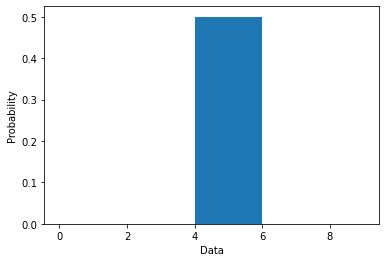

In [227]:
%matplotlib inline 
plt.hist(data, bins_list, density=True)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

ValueError: `bins` must increase monotonically, when an array

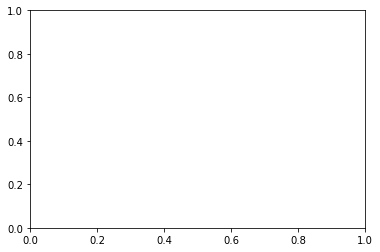

In [226]:
%matplotlib inline 
plt.hist(bins_list, data, density=True)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [228]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [139]:
all_mean[0], all_var[0]

([0.011185832428280263, 0.004691238684586931],
 [0.003273453806956618, 0.001557183303334834])

In [ ]:
plot_figures_non_numeric

In [ ]:
if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)

In [36]:
predictions, prob_df = class_prob(input_batch[0].unsqueeze(0), 1000)
predictions

NameError: name 'input_batch' is not defined

In [309]:
df_mean_std, df_mean, df_std = mean_std(prob_df)

In [310]:
for i in predictions:
    print("pre", i, "mean", df_mean[i], "std", df_std[i], "std/mean", df_std[i]/df_mean[i])


pre 0 mean 0.24536213626878028 std 0.020665701908594288 std/mean 0.08422530967025893
pre 2 mean 0.4497839583274736 std 0.02991625371386265 std/mean 0.06651249596607793
pre 3 mean 0.3775997192519741 std 0.027850549789916836 std/mean 0.07375680746026199


In [256]:
# for i in range(10):
#     print("pre", i, "mean", df_mean[i], "std", df_std[i], "std/mean", df_std[i]/df_mean[i])

In [274]:
df_mean, df_std

(0    0.129948
 1    0.087413
 2    0.222882
 3    0.190515
 4    0.042025
 5    0.058878
 6    0.035336
 7    0.143248
 8    0.042088
 9    0.047666
 Name: mean, dtype: float64,
 0    0.020063
 1    0.011761
 2    0.028414
 3    0.026746
 4    0.005851
 5    0.010921
 6    0.006530
 7    0.017015
 8    0.005521
 9    0.006889
 Name: std, dtype: float64)

In [258]:
200

11

5-mult pre
-> 6 single pre

SyntaxError: invalid syntax (<ipython-input-258-170f4be5ac97>, line 5)

In [259]:
# MCMC? 
# Insted of selecting the highest, 
# Confidence of the prediction

In [77]:
# Insted of choosing the image with the hiest proability, now it will seleted given their probability

In [275]:

df_mean.sample(weights=df_mean, n=2)

3    0.190515
7    0.143248
Name: mean, dtype: float64

In [312]:
predictions, prob_df = class_prob(example_data[0].unsqueeze(0), 1000)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [313]:
df_mean_std, df_mean, df_std = mean_std(prob_df)

In [314]:
df_mean

0    3.179581e-05
1    1.790249e-07
2    3.037687e-06
3    4.890642e-06
4    1.825834e-07
5    5.334930e-07
6    1.007063e-10
7    9.972818e-01
8    2.938128e-06
9    2.674664e-03
Name: mean, dtype: float64

In [315]:
df_mean.sample(weights=df_mean, n=10)

7    9.972818e-01
9    2.674664e-03
0    3.179581e-05
3    4.890642e-06
8    2.938128e-06
2    3.037687e-06
4    1.825834e-07
5    5.334930e-07
1    1.790249e-07
6    1.007063e-10
Name: mean, dtype: float64

In [316]:
df_mean.sample(weights=df_mean, n=1, replace=True)

7    0.997282
Name: mean, dtype: float64

In [317]:
len(prob_df.columns)

1002

In [318]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,mean,std
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,1.330914e-05,1.505631e-05,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,4.251460e-08,1.510466e-07,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,9.068695e-07,2.763991e-06,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,1.304533e-06,1.026684e-05,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,4.970365e-08,1.270573e-07,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,1.227872e-07,2.619772e-07,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,1.010350e-11,5.167334e-11,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.987313e-01,9.978337e-01,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,4.584777e-07,4.474739e-06,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,1.252541e-03,2.133263e-03,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03


In [349]:
def select_given_prob(df_prob, mean_var = False):
    df_copy = df_prob.copy()
    extra_columns = 0
    if mean_var:
        extra_columns = 2
        
    df_copy['count']= 0
    for i in range(len(df_copy.columns)-1-extra_columns):
        number_pre_data = df_copy.iloc[:, i].sample(weights=df_mean, n=1, replace=True)
        number_pre = number_pre_data.axes[0][0]
        df_copy['count'].iloc[number_pre] += 1
    
    num_pre = df_copy['count'].sum() 
    df_copy['ratio']= 0
    for i in range(10):
        df_copy['ratio'].iloc[i] = df_copy_count.iloc[i]/num_pre

    df_copy

    return df_copy, df_copy['count'], df_copy['ratio']
    
    

In [350]:
df_copy, df_copy_count, df_copy_ratio = select_given_prob(prob_df, True)

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [351]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,mean,std,count,ratio
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,1,0.000
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0,0.000
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0,0.000
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0,0.000
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0,0.000
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0,0.000
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0,0.000
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998,0.998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0,0.000
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,1,0.002


In [347]:
df_copy_count.iloc[3]

0

In [339]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,mean,std,count
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,1.505631e-05,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,0
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.510466e-07,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.763991e-06,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,1.026684e-05,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.270573e-07,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,2.619772e-07,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,5.167334e-11,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.978337e-01,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,4.474739e-06,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,2.133263e-03,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,2


In [348]:
num_pre = df_copy['count'].sum() 
df_copy['ratio']= 0
for i in range(10):
    df_copy['ratio'].iloc[i] = df_copy_count.iloc[i]/num_pre
    
df_copy

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,mean,std,count,ratio
0,5.786133e-05,1.680088e-05,1.843576e-05,4.676656e-05,2.486203e-05,1.312825e-05,5.217447e-05,3.276578e-05,1.397870e-05,7.624463e-06,...,2.093480e-05,7.249072e-05,4.098866e-05,7.077481e-05,3.535974e-05,8.735839e-06,3.179581e-05,2.110827e-05,0,0.000
1,2.009263e-07,5.542262e-08,7.492642e-08,3.452470e-07,1.275317e-07,7.933328e-08,1.528586e-07,2.379759e-07,1.159817e-07,1.052082e-07,...,1.937292e-07,2.944793e-07,1.670341e-07,2.128708e-07,1.434298e-07,2.043343e-07,1.790249e-07,1.303487e-07,0,0.000
2,2.360174e-06,1.469879e-06,1.216247e-06,4.527731e-06,1.508619e-06,1.841414e-06,3.082323e-06,5.322615e-06,1.981753e-06,2.069302e-06,...,2.090722e-06,5.006623e-06,3.191562e-06,4.122724e-06,2.658724e-06,2.693520e-06,3.037687e-06,2.110683e-06,0,0.000
3,5.659792e-06,3.245853e-06,2.512084e-06,6.345012e-06,2.567281e-06,1.955944e-06,4.887081e-06,4.614725e-06,2.623509e-06,3.136851e-06,...,2.908601e-06,1.093526e-05,3.110321e-06,8.947503e-06,4.051968e-06,3.556379e-06,4.890642e-06,2.945971e-06,0,0.000
4,1.375029e-07,1.298779e-07,9.395692e-08,1.682389e-07,1.111358e-07,7.068157e-08,3.698746e-07,1.267583e-07,6.818291e-08,3.781333e-08,...,1.429961e-07,1.263814e-07,8.393334e-08,1.323948e-07,2.508548e-07,1.420082e-07,1.825834e-07,1.324355e-07,0,0.000
5,1.226283e-06,6.136302e-07,4.104684e-07,6.487342e-07,3.192314e-07,1.905831e-07,4.307044e-07,1.402837e-07,5.042707e-07,8.048669e-08,...,5.385176e-07,4.291461e-07,3.318698e-07,6.180121e-07,9.507860e-07,3.665075e-07,5.334930e-07,3.779815e-07,0,0.000
6,1.939716e-10,4.610395e-11,3.435379e-11,1.580480e-10,6.396388e-11,4.501236e-11,6.885682e-11,7.121559e-11,4.027580e-11,6.389429e-12,...,6.110502e-11,1.562171e-10,6.866795e-11,1.217812e-10,1.012197e-10,4.482611e-11,1.007063e-10,9.693912e-11,0,0.000
7,9.973431e-01,9.979143e-01,9.969395e-01,9.934077e-01,9.989318e-01,9.984137e-01,9.963434e-01,9.983204e-01,9.979061e-01,9.990797e-01,...,9.962873e-01,9.962801e-01,9.978266e-01,9.972239e-01,9.971330e-01,9.985967e-01,9.972818e-01,1.380365e-03,998,0.998
8,4.203310e-06,2.068335e-06,1.466677e-06,2.917060e-06,1.566329e-06,1.492971e-06,3.020164e-06,3.198017e-06,2.581771e-06,1.433390e-06,...,2.817834e-06,2.434269e-06,2.693851e-06,4.446837e-06,7.217890e-06,2.789010e-06,2.938128e-06,1.861939e-06,0,0.000
9,2.585214e-03,2.061395e-03,3.036231e-03,6.530506e-03,1.037058e-03,1.567584e-03,3.592474e-03,1.633149e-03,2.072043e-03,9.057500e-04,...,3.683057e-03,3.628106e-03,2.122811e-03,2.686934e-03,2.816292e-03,1.384777e-03,2.674664e-03,1.368773e-03,2,0.002


In [296]:
from numpy.random import randint
prob_df['count']= 0

In [297]:
prob_df['count'].iloc[3] += 4

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [298]:
prob_df

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,mean,std,count
0,0.130911,0.142219,0.100141,0.138963,0.178014,0.102269,0.130821,0.212237,0.126294,0.117447,...,0.119132,0.167600,0.137392,0.108345,0.133773,0.128730,0.129042,0.129948,0.020063,0
1,0.103097,0.083120,0.089822,0.082840,0.061957,0.086554,0.086526,0.065816,0.083830,0.080343,...,0.087048,0.076157,0.093241,0.094716,0.082594,0.086262,0.089363,0.087413,0.011761,0
2,0.277607,0.236581,0.224060,0.251009,0.153469,0.263393,0.182760,0.233874,0.299642,0.302925,...,0.187143,0.228817,0.220027,0.213651,0.225980,0.215116,0.192828,0.222882,0.028414,0
3,0.146723,0.186218,0.211143,0.177288,0.198238,0.217215,0.205661,0.138318,0.179516,0.162538,...,0.199526,0.172156,0.150902,0.196476,0.207280,0.192228,0.177791,0.190515,0.026746,4
4,0.043442,0.038655,0.040615,0.040204,0.042034,0.038904,0.044831,0.037552,0.036126,0.047026,...,0.043149,0.034245,0.051814,0.043928,0.033060,0.045778,0.045317,0.042025,0.005851,0
5,0.053583,0.050095,0.052643,0.048457,0.091790,0.043464,0.066651,0.057342,0.039951,0.046624,...,0.075636,0.052358,0.067265,0.052902,0.054592,0.069570,0.064493,0.058878,0.010921,0
6,0.037714,0.036856,0.027726,0.034086,0.036261,0.026254,0.035831,0.041264,0.028064,0.039638,...,0.036502,0.037466,0.043578,0.026574,0.033638,0.036047,0.032772,0.035336,0.006530,0
7,0.130618,0.133070,0.168251,0.127187,0.132426,0.151473,0.148345,0.126536,0.131262,0.132068,...,0.154356,0.146254,0.139123,0.173832,0.149183,0.133001,0.162112,0.143248,0.017015,0
8,0.036577,0.048571,0.037790,0.050588,0.047300,0.031294,0.038768,0.039298,0.037601,0.042047,...,0.041325,0.038816,0.043109,0.041961,0.040216,0.047397,0.037902,0.042088,0.005521,0
9,0.039728,0.044616,0.047810,0.049378,0.058511,0.039179,0.059806,0.047762,0.037715,0.029344,...,0.056183,0.046131,0.053550,0.047616,0.039684,0.045871,0.068379,0.047666,0.006889,0


In [ ]:
def pre_test_data(data, pred_fun)
pre = []
list_multiple_sol = []
multiple_predictions_list = []

std_sol = []
std_multiple_sol = []

mean_sol = []
mean_multiple_sol = []

all_pre =[]
all_mean =[]
all_var =[]
for i in range(200):
    
    predictions, prob_df = class_prob(example_data[i].unsqueeze(0), 100)
    predictions_list = list(predictions)
    
    if len(predictions_list)>1:
        print("multiple solutions in", i)
        list_multiple_sol.append(i)
        multiple_predictions_list.append(predictions_list)
        all_pre.append(predictions_list)
        
        std_sol.append(0)
        mean_sol.append(10)
        pre.append(10)
        
        std_saver = []
        mean_saver = []
        for m in predictions_list:
            df_mean_std, df_mean, df_std = mean_std(prob_df)
            std_saver.append(df_std[m])
            mean_saver.append(df_mean[m])
        std_multiple_sol.append(std_saver)
        mean_multiple_sol.append(mean_saver)
        
        all_var.append(std_saver)
        all_mean.append(mean_saver)
    else:
        
        df_mean_std, df_mean, df_std = mean_std(prob_df)
        std_sol.append(df_std[predictions_list[0]])
        mean_sol.append(df_mean[predictions_list[0]])
        pre.append(predictions_list[0])
        
        all_var.append(df_std[predictions_list[0]])
        all_mean.append(df_mean[predictions_list[0]])
        all_pre.append(predictions_list)


In [ ]:
def plot_figures_non_numeric(images_list, all_predictions = [], all_mean_sol =[], all_std_sol=[]):
    fig = plt.figure()
    counter = 0
    for i in images_index_list:
        plt.subplot(math.ceil(len(images_index_list)/3),3, 1 + counter)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
        counter += 1
    fig
    
    if all_predictions != []:
        counter = 1
        for i in images_index_list:
            print("~~~~~~~~~~~~~~~~~ Image " +str(counter)+ " ~~~~~~~~~~~~~~~~~")
            print("predictions", all_predictions[i], " ground truth", example_targets[i].item())
            print("mean:", all_mean_sol[i])
            print("std:", all_std_sol[i])
            counter+=1
            std_mean_saver = []
            if len(all_predictions[i])> 1:
                for n in range(len(all_predictions[i])):
                    std_mean = all_std_sol[i][n]/all_mean_sol[i][n]
                    std_mean_saver.append(std_mean)
                    
                print("std/mean:", std_mean_saver)
                
            else:
                print("std/mean:", all_std_sol[i]/all_mean_sol[i])